In [1]:
# %pip install torch
# %pip install pymoo
# %pip install pywin32

In [2]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

print(parent_dir)
from localityaware.module import *
from NSGA_nn.nsga import *
from Vinyl_Distillation.VCDistillation import *

Added to sys.path: C:\Users\conno\OneDrive\Desktop\Aspen\Aspen
C:\Users\conno\OneDrive\Desktop\Aspen\Aspen
['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\\python313.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\conno\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages', 'C:\\Users\\conno\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\win32', 'C:\\Users\\conno\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\sit

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import time

# Define the file path for saving/loading the data
data_file = "vcdistil.pkl"



print("Generating new data...")
assSim = VCDistillation(AspenFile="Vinyl Chloride Distillation.bkp", 
                        wdpath="../Vinyl_Distillation", 
                        visibility=True)

Generating new data...
The current Directory is :  
C:\Users\conno\OneDrive\Desktop\Aspen\Aspen\Vinyl_Distillation
The new Directory where you should also have your Aspen file is : 
C:\Users\conno\OneDrive\Desktop\Aspen\Aspen\Vinyl_Distillation
Aspen is active now. If you dont want to see aspen open again take VISIBITLY as False 



In [4]:
import numpy as np
import time
from scipy.stats import qmc

# Number of samples you want to generate
N = 100  # change this as needed

# Define lower and upper bounds for the 8 parameters
lower_bounds = np.array([
    30,    # trays low
    2,     # feed position low
    0.1,   # reflux ratio low
    0.46,  # distillate-to-feed ratio low
    35,    # trays high
    2,     # feed position high
    0.1,   # reflux ratio high
    0.89   # distillate-to-feed ratio high
])

upper_bounds = np.array([
    36,    # trays low
    29,    # feed position low
    1.5,   # reflux ratio low
    0.48,  # distillate-to-feed ratio low
    42,    # trays high
    34,    # feed position high
    1.5,   # reflux ratio high
    0.91   # distillate-to-feed ratio high
])


# Initialize the Latin Hypercube sampler for 8 dimensions
sampler = qmc.LatinHypercube(d=8)
sample_unit = sampler.random(n=N)  # Samples in [0, 1) with shape (N,8)

# Scale the samples to the desired parameter ranges
samples = qmc.scale(sample_unit, lower_bounds, upper_bounds)

# print("samples_scaled", samples_scaled)

# For integer parameters, round the values.
# We assume indices 0, 1, 4, and 5 are integers.
samples[:, 0] = np.round(samples[:, 0]).astype(int)
samples[:, 1] = np.round(samples[:, 1]).astype(int)
samples[:, 4] = np.round(samples[:, 4]).astype(int)
samples[:, 5] = np.round(samples[:, 5]).astype(int)

# For debugging: print the first few samples
print("First 5 LHS samples (each row corresponds to [trays low, feed low, reflux low, dist-feed low, trays high, feed high, reflux high, dist-feed high]):")
print(samples[:5])

First 5 LHS samples (each row corresponds to [trays low, feed low, reflux low, dist-feed low, trays high, feed high, reflux high, dist-feed high]):
[[36.         14.          0.1277515   0.46740054 36.         15.
   0.42449725  0.90173545]
 [35.         15.          0.40905271  0.4741199  40.         24.
   0.20500358  0.89670411]
 [34.         10.          1.4358265   0.46694528 35.         22.
   1.41257292  0.89550332]
 [35.          3.          0.72869439  0.47819149 38.          7.
   0.66589366  0.89248252]
 [35.         11.          0.91794139  0.46104178 42.          3.
   0.78269778  0.90538838]]


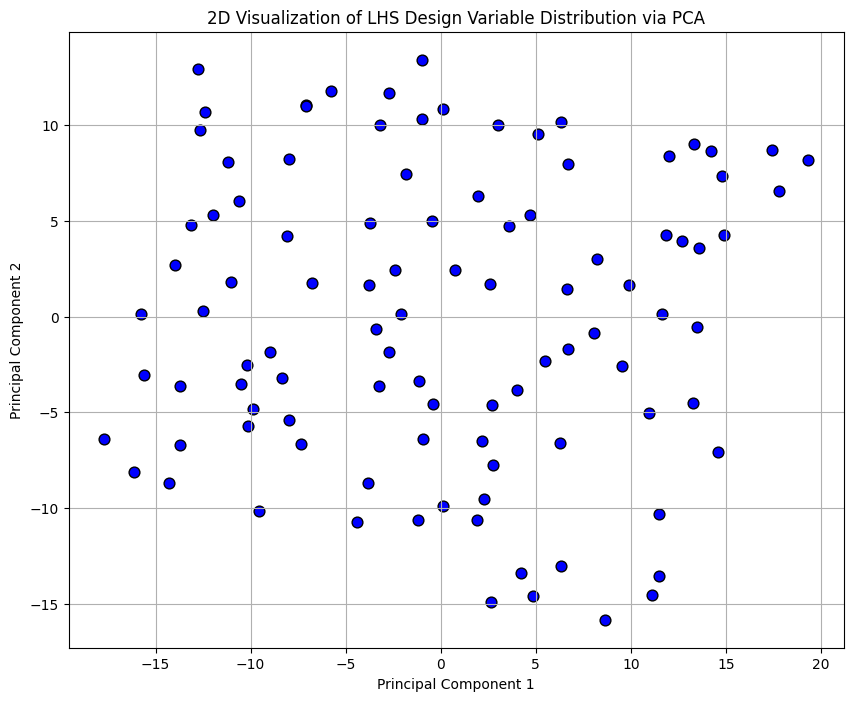

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Here, we assume samples_scaled is a NumPy array with shape (N, 8)
# representing your 8 design variables from LHS.
X_params = samples[:, :8]

# Apply PCA to reduce the 8-dimensional parameter space to 2 dimensions.
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_params)

# Create a scatter plot for the reduced parameters.
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue', edgecolor='k', s=60)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of LHS Design Variable Distribution via PCA')
plt.grid(True)
plt.show()


In [6]:
# Start timing the data generation (simulation evaluations)
            # first, import the module normally

start_time = time.time()

data_sim = []

for param_array in samples:
    # Convert the 8 parameters into the expected input format
    x_unflat = assSim.unflatten_params(param_array)
    print(x_unflat['RadFrac'])
    # Run the objective function (this is where the Aspen or dummy simulation is called)
    results = assSim.runSim(x_unflat)
    output = assSim.costFunc(results)
    data_sim.append(list(param_array) + list(output))
print(data_sim[:2])
data_sim = np.array(data_sim)
elapsed = time.time() - start_time


hi
{'RADFRAC1': [np.float64(36.0), [np.float64(14.0), 'FEED'], np.float64(0.12775150005196317), np.float64(0.4674005358107983)], 'RADFRAC2': [np.float64(36.0), [np.float64(15.0), 'B1'], np.float64(0.42449725387215553), np.float64(0.9017354484155805)]}
[np.float64(36.0), [np.float64(14.0), 'FEED'], np.float64(0.12775150005196317), np.float64(0.4674005358107983)]
[np.float64(36.0), [np.float64(15.0), 'B1'], np.float64(0.42449725387215553), np.float64(0.9017354484155805)]
hi
{'RADFRAC1': [np.float64(35.0), [np.float64(15.0), 'FEED'], np.float64(0.4090527058800211), np.float64(0.474119895233978)], 'RADFRAC2': [np.float64(40.0), [np.float64(24.0), 'B1'], np.float64(0.20500357967332333), np.float64(0.8967041056997077)]}
[np.float64(35.0), [np.float64(15.0), 'FEED'], np.float64(0.4090527058800211), np.float64(0.474119895233978)]
[np.float64(40.0), [np.float64(24.0), 'B1'], np.float64(0.20500357967332333), np.float64(0.8967041056997077)]
hi
{'RADFRAC1': [np.float64(34.0), [np.float64(10.0), 'F

In [7]:

print(f"Generated {len(data_sim)} simulation points in {elapsed:.2f} seconds.")


# import pickle
# with open("../NSGA_nn/results/vinyl/data_sim_12dim.pkl", "wb") as f:
#     pickle.dump({"data": data_sim, "time_sec": elapsed}, f)

data_sim = np.array(data_sim)
data_gen_time = time.time() - start_time  # Total time to generate data
total_original_assSim_calls = len(data_sim)

Generated 100 simulation points in 288.16 seconds.


In [8]:
# import pickle
# with open('../NSGA_nn/results/vinyl/data_sim_12dim.pkl', 'rb') as f:
#     out = pickle.load(f)
# data_sim = out['data']

In [9]:
print(data_sim[0])
print(len(data_sim[0]))

[3.60000000e+01 1.40000000e+01 1.27751500e-01 4.67400536e-01
 3.60000000e+01 1.50000000e+01 4.24497254e-01 9.01735448e-01
 3.82628931e-02 9.99872105e-01 3.39224288e+05 5.93528772e+03]
12


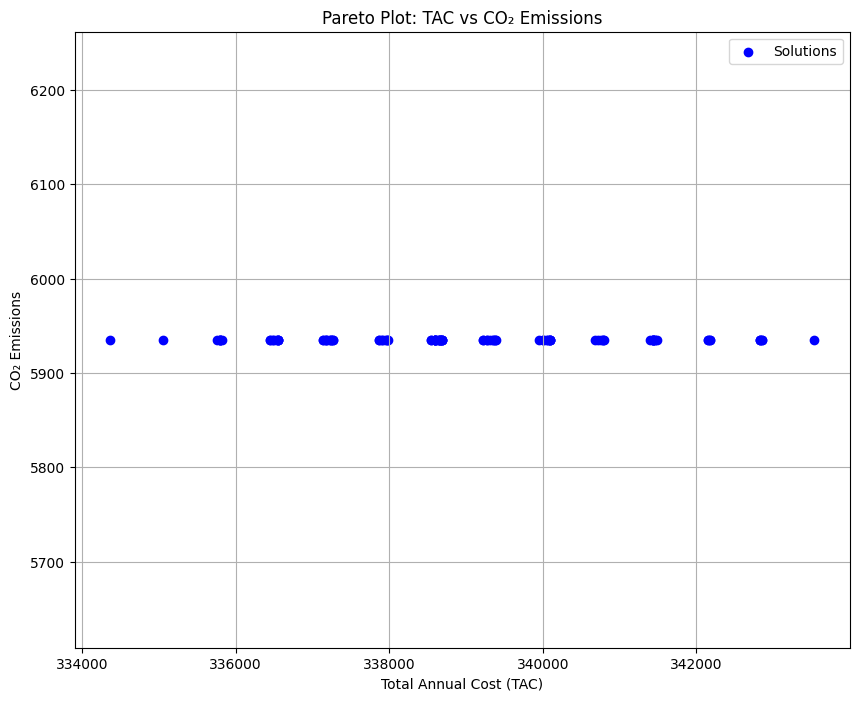

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# For demonstration purposes, assume you have an array of objectives
# with shape (N, 2) where each row is [TAC, CO₂ Emissions].
# Replace this with your actual data.
objectives = data_sim[:, -2:]  # Assuming the last two columns are the objectives
plt.figure(figsize=(10, 8))
plt.scatter(objectives[:, 0], objectives[:, 1], color='blue', marker='o', label="Solutions")
plt.xlabel('Total Annual Cost (TAC)')
plt.ylabel('CO₂ Emissions')
plt.title('Pareto Plot: TAC vs CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
print(len(data_sim))

# Instantiate the scaler with your provided ranges for 8-D inputs and 2-D outputs.
scaler = TorchMinMaxScaler(
    feature_range=(-1, 1), 
    max_vals=[36, 29, 1.5, 0.48, 42, 34, 1.5, 0.91],  # maximum for each of the 8 input parameters
    min_vals=[30, 2, 0.1, 0.46, 35, 2, 0.1, 0.89],       # minimum for each of the 8 inputs
    scale_y=True,
    min_y=[0, 0, 1e5, 1e4],   # minimum for the 4 outputs (e.g., acetyl purity, vinyl purity, TAC and CO₂)
    max_y=[1, 1, 1e6, 6e5]    # maximum for the 4 outputs
)

# Correct: use data_sim[:, :8] for inputs, and data_sim[:, 8:] for outputs.
data_sim_xscaled, data_sim_yscaled = scaler.transform(data_sim[:, :8], data_sim[:, 8:])

# Convert the PyTorch tensors to NumPy arrays.
data_sim_xscaled = data_sim_xscaled.detach().cpu().numpy()
data_sim_yscaled = data_sim_yscaled.detach().cpu().numpy()

# Check shapes for debugging:
print("Shape of scaled inputs:", data_sim_xscaled.shape)   # should be (N, 8)
print("Shape of scaled outputs:", data_sim_yscaled.shape)    # should be (N, 2)

# Recombine scaled inputs and outputs into one array with 10 columns (8 + 2).
data_sim_scaled = np.column_stack([data_sim_xscaled, data_sim_yscaled])
print("Shape of combined scaled data:", data_sim_scaled.shape)
print("First few rows of combined scaled data:\n", data_sim_scaled[:5])


# **Initialize Model & Dataset**
dataset = DynamicDataset(data_sim_scaled, num_inputs=8)
model = MLP(8, [50, 50, 20, 20, 50, 50], 4)

print("Dataset and model initialized.")

100
Shape of scaled inputs: (100, 8)
Shape of scaled outputs: (100, 4)
Shape of combined scaled data: (100, 12)
First few rows of combined scaled data:
 [[ 1.         -0.1111111  -0.960355   -0.25994837 -0.71428573 -0.1875
  -0.5364325   0.17354095 -0.9234742   0.9997442  -0.46839046 -1.0137787 ]
 [ 0.6666666  -0.03703701 -0.5584961   0.41199005  0.42857146  0.375
  -0.8499949  -0.32959247 -0.9234742   0.9997442  -0.4634744  -1.0137787 ]
 [ 0.33333337 -0.4074074   0.90832365 -0.30547142 -1.          0.25
   0.87510407 -0.44966573 -0.9234742   0.9997442  -0.47303963 -1.0137787 ]
 [ 0.6666666  -0.9259259  -0.10186517  0.8191495  -0.14285713 -0.6875
  -0.19158047 -0.75174725 -0.9234742   0.9997442  -0.4666677  -1.0137787 ]
 [ 0.6666666  -0.3333333   0.16848767 -0.89582294  1.         -0.9375
  -0.02471745  0.53883314 -0.9234742   0.9997442  -0.4603142  -1.0137787 ]]
Dataset and model initialized.


In [12]:
from VCDistillation import VinylDistillationNNProblem
threshold_scaler = TorchMinMaxScaler(
    feature_range=(-1, 1),
    min_vals=[0,0],  # Input bounds for 8 variables
    max_vals=[1,1],
    scale_y=False
)
problem = VinylDistillationNNProblem(model,threshold_scaler)

acetyl_threshold -0.999
vc_threshold 0.99979997


In [14]:
out = optimize_surr_nsga(model=model,
                   dataset=dataset,
                   assSim=assSim,
                   problem=problem,
                   lrs={'first':1e-4, 'others':1e-4},
                   epochs={'first':2000, 'others':300},
                   min_vals=scaler.min_x,
                   max_vals=scaler.max_x,
                   scaler=scaler,
                   device='cpu',
                   iter=5,
                   print_loss=True,
                   print_it_data=True,
                   pop_size=1000,
                   n_gen = 10,
                   new_data_size=20,
                   batch_size=100
                   )

Iteration 0: Training surrogate model...
Epoch 0: Total Loss=0.0324
Epoch 50: Total Loss=0.0140
Epoch 100: Total Loss=0.0071
Epoch 150: Total Loss=0.0039
Epoch 200: Total Loss=0.0023
Epoch 250: Total Loss=0.0014
Epoch 300: Total Loss=0.0009
Epoch 350: Total Loss=0.0007
Epoch 400: Total Loss=0.0005
Epoch 450: Total Loss=0.0004
Epoch 500: Total Loss=0.0003
Epoch 550: Total Loss=0.0002
Epoch 600: Total Loss=0.0002
Epoch 650: Total Loss=0.0002
Epoch 700: Total Loss=0.0002
Epoch 750: Total Loss=0.0001
Epoch 800: Total Loss=0.0001
Epoch 850: Total Loss=0.0001
Epoch 900: Total Loss=0.0001
Epoch 950: Total Loss=0.0001
Epoch 1000: Total Loss=0.0001
Epoch 1050: Total Loss=0.0001
Epoch 1100: Total Loss=0.0001
Epoch 1150: Total Loss=0.0001
Epoch 1200: Total Loss=0.0001
Epoch 1250: Total Loss=0.0000
Epoch 1300: Total Loss=0.0000
Epoch 1350: Total Loss=0.0000
Epoch 1400: Total Loss=0.0000
Epoch 1450: Total Loss=0.0000
Epoch 1500: Total Loss=0.0000
Epoch 1550: Total Loss=0.0000
Epoch 1600: Total Loss

In [ ]:
import os
import datetime
import pickle

data_gen_time = 0
total_original_assSim_calls = 100

print(os.getcwd())
# Get current notebook name manually (or hardcode it here)
notebook_name = "vinyl"  # or os.path.basename(__file__).replace(".py", "")

# Get timestamp
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct path: results/<notebook_name>/run_<timestamp>/
base_dir = os.path.join("../NSGA_nn/results", notebook_name)
save_dir = os.path.join(base_dir, f"run_{now}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

print(f"Results will be saved in: {save_dir}")

# Save out.pkl
out["data_gen_time"] = data_gen_time
out["total_original_assSim_calls"] = total_original_assSim_calls
with open(os.path.join(save_dir, "out.pkl"), "wb") as f:
    pickle.dump(out, f)

# Save scaler
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Save dataset
with open(os.path.join(save_dir, "dataset.pkl"), "wb") as f:
    pickle.dump(dataset, f)

print(f"Saved all results in {save_dir}")
